# Nonlinear Time-History on MDOF System

## Introduction

This Jupyter Notebook provides a structured workflow for performing a nonlinear time-history analyses (NLTHA) on multi-degree-of-freedom (MDOF) stick-and-mass structural models using a single record. By combining functions for MDOF modeling and dynamic analysis, the notebook enables the setup, execution, and post-processing of structural responses under earthquake loading.

The main goals of this notebook:

1. **Compile and construct MDOF Models in OpenSees**: Define and assemble MDOF models by specifying essential structural properties, including mass, heights and nonlinear response characteristics at each degree of freedom

2. **Run Nonlinear Time-History Analysis (NLTHA) in OpenSees**: Simulate the dynamic response of MDOF structures under time-dependent inputs, such as ground motion records, to realistically assess structural behavior and response metrics (e.g., peak storey drifts, peak floor accelerations) under loading conditions and extract critical response metrics and model information.

3. **Export Response Quantities from NLTHA**: Postprocess response quantities from NLTHA in a ready-to-use format by other OQ-VMTK modules and functions

4. **Visualise Seismic Demands from NLTHA**: Visualise the seismic demand profiles (i.e., the distribution of peak storey drift and peak floor acceleration values along the height of the idealised MDOF model).

## Initialize Libraries ##

In [1]:
import os
import sys
import shutil
import numpy as np
import pandas as pd

# Import the classes necessary for structural analysis
from openquake.vmtk.units         import units              # oq-vtmk units class
from openquake.vmtk.modeller      import modeller           # oq-vmtk numerical modelling class
from openquake.vmtk.plotter       import plotter            # oq-vmtk plotting class
from openquake.vmtk.utilities     import export_to_pkl      # oq-vmtk utilities class

## Define Directories ##

In [2]:
# Define the directory of the ground-motion records
gm_directory  = './records'            

# Define the main output directory
nrha_directory = './output'  
os.makedirs(nrha_directory, exist_ok=True)

# Define directory for temporary analysis outputs: it is used to store temporary .txt files used as accelerations recorders
temp_nrha_directory = os.path.join(nrha_directory,'temp')
os.makedirs(temp_nrha_directory, exist_ok=True)

## Required MDOF Modelling Input Parameters ##

In [9]:
# Number of storeys
number_storeys = 3 

# Relative floor heights list
floor_heights = [2.80, 3.00, 3.00]

# Relative floor masses list
floor_masses = [0.75, 0.75, 0.75] # Unit mass for SDOFs

# SDOF capacity (First row are Spectral Displacement [m] values - Second row are Spectral Acceleration [g] values)
# 3 storeys × 4 points each
storey_disps = np.array([
    [0.05, 0.10, 0.20, 0.30],   # storey 1
    [0.06, 0.12, 0.25, 0.35],   # storey 2
    [0.07, 0.14, 0.30, 0.40]    # storey 3
])

storey_forces = np.array([
    [50, 100, 75, 60],  # storey 1
    [60, 120, 90, 70],  # storey 2
    [70, 140, 100, 80]   # storey 3
]) * units.kN   # or *units.g depending on definition

# Flag to activate default stiffness-strength degradation and pinching4
mdof_degradation = True

## Setting Up, Running NLTHA and Exporting Analysis ##

WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 3, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 3, which is greater than the tolerance


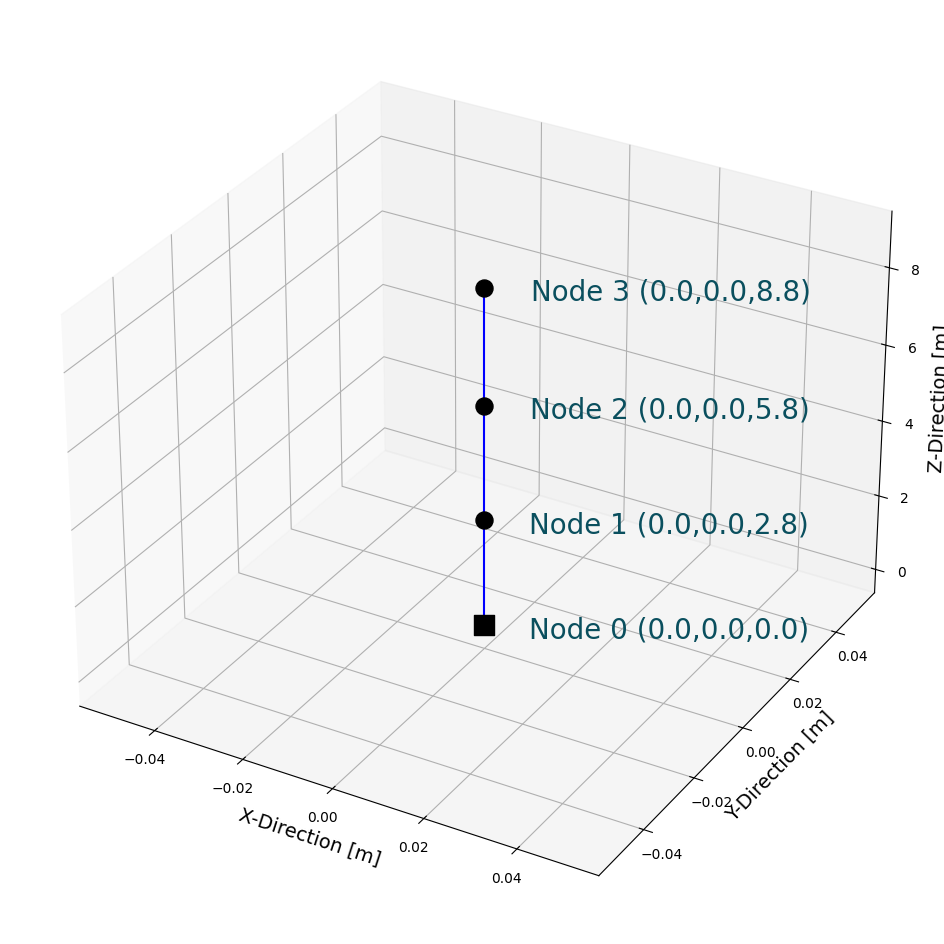

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
Peak drift values in X-direction: [0.00281444 0.00206069 0.00113315] rad
Peak drift values in Y-direction: [0. 0. 0.] rad
Peak acceleration values in X-direction: [1.7623241590214065, 2.320030581039755, 3.6425688073394498, 4.450305810397553] g
Peak acceleration values in Y-direction: [0.0, 0.0, 0.0, 0.0] g
Maximum peak storey drift value of 0.002814435883644258 encountered in X direction on storey # 1
Maximum peak floor acceleration value of 4.450305810397553 encountered in X direction on storey # 3
ANALYSIS COMPLETED!


In [10]:
# Initialise MDOF storage lists
conv_index_list = []               # List for convergence indices
peak_disp_list  = []               # List for peak floor displacement (returns all peak values along the building height)
peak_drift_list = []               # List for peak storey drift (returns all peak values along the building height)
peak_accel_list = []               # List for peak floor acceleration (returns all peak values along the building height)
max_peak_drift_list = []           # List for maximum peak storey drift (returns the maximum value) 
max_peak_drift_dir_list = []       # List for maximum peak storey drift directions
max_peak_drift_loc_list = []       # List for maximum peak storey drift locations
max_peak_accel_list = []           # List for maximum peak floor acceleration (returns the maximum value)
max_peak_accel_dir_list = []       # List for maximum peak floor acceleration directions 
max_peak_accel_loc_list = []       # List for maximum peak floor acceleration locations

### Compile the MDOF model    
model = modeller(number_storeys,
                 floor_heights,
                 floor_masses,
                 storey_disps,
                 storey_forces*units.g,
                 mdof_degradation)                                                                # Initialise the class (Build the model)

model.compile_model()                                                                             # Compile the MDOF model

model.plot_model()                                                                                # Visualise the model (only on first iteration)        
model.do_gravity_analysis()                                                                       # Do gravity analysis

num_modes = 3
T, phi = model.do_modal_analysis(num_modes = num_modes)                                           # Do modal analysis and get period of vibration (Essential step for running NLTHA)

### Define ground motion objects
fnames = [os.path.join(gm_directory,'acc.csv')]                                           # Ground-motion record names
fdts   =  os.path.join(gm_directory,'dts.csv')                                            # Ground-motion time-step names 
dt_gm = pd.read_csv(fdts, header=None)[pd.read_csv(fdts,header=None).columns[0]].loc[1]-\
        pd.read_csv(fdts, header=None)[pd.read_csv(fdts,header=None).columns[0]].loc[0]           # Ground-motion time-step
t_max = pd.read_csv(fdts)[pd.read_csv(fdts).columns[0]].iloc[-1]                                  # Ground-motion duration
    
### Define analysis params and do NLTHA
dt_ansys = dt_gm                                                          # Set the analysis time-step
sf = units.g                                                              # Set the scaling factor (Note: if records are in g, an additional scaling factor of 9.81 m/s2 must be used to be consistent with opensees) 
control_nodes, conv_index, peak_drift, peak_accel, max_peak_drift, max_peak_drift_dir, max_peak_drift_loc, max_peak_accel, max_peak_accel_dir, max_peak_accel_loc, peak_disp = model.do_nrha_analysis(fnames, 
                                                                                                                                                                                                      dt_gm, 
                                                                                                                                                                                                      sf, 
                                                                                                                                                                                                      t_max, 
                                                                                                                                                                                                      dt_ansys,
                                                                                                                                                                                                      temp_nrha_directory,
                                                                                                                                                                                                      pflag=False,
                                                                                                                                                                                                      xi = 0.05)

print('Peak drift values in X-direction:', peak_drift[:,0], 'rad') # Peak drift values in the X-direction
print('Peak drift values in Y-direction:', peak_drift[:,1], 'rad') # Peak drift values in the Y-direction (Zeros due to uni-directional loading)
print('Peak acceleration values in X-direction:', [x/9.81 for x in peak_accel[:,0]], 'g') # Peak acceleration values in the X-direction (converted to g)
print('Peak acceleration values in Y-direction:', [x/9.81 for x in peak_accel[:,1]], 'g') # Peak acceleration values in the Y-direction (converted to g)
print('Maximum peak storey drift value of', max_peak_drift, 'encountered in', max_peak_drift_dir ,'direction', 'on storey #', max_peak_drift_loc)       # Reporting
print('Maximum peak floor acceleration value of', max_peak_accel/9.81, 'encountered in', max_peak_accel_dir ,'direction', 'on storey #', max_peak_accel_loc) # Reporting

### Store the analysis
conv_index_list.append(conv_index)
peak_drift_list.append(peak_drift)
peak_accel_list.append(peak_accel)
peak_disp_list.append(peak_disp)
max_peak_drift_list.append(max_peak_drift)
max_peak_drift_dir_list.append(max_peak_drift_dir)
max_peak_drift_loc_list.append(max_peak_drift_loc)
max_peak_accel_list.append(max_peak_accel)
max_peak_accel_dir_list.append(max_peak_accel_dir)
max_peak_accel_loc_list.append(max_peak_accel_loc)

# Store the analysis results in a dictionary compatible with required input from other OQ-VMTK modules and functions
ansys_dict = {}
labels = ['T','control_nodes', 'conv_index_list',
          'peak_drift_list','peak_accel_list',
          'max_peak_drift_list', 'max_peak_drift_dir_list', 
          'max_peak_drift_loc_list','max_peak_accel_list',
          'max_peak_accel_dir_list','max_peak_accel_loc_list',
          'peak_disp_list']

for i, label in enumerate(labels):
    ansys_dict[label] = vars()[f'{label}']
# Export the analysis output variable to a pickle file using the "export_to_pkl" function from "utilities"
export_to_pkl(os.path.join(nrha_directory,'ansys_out.pkl'), ansys_dict) 

print('ANALYSIS COMPLETED!')

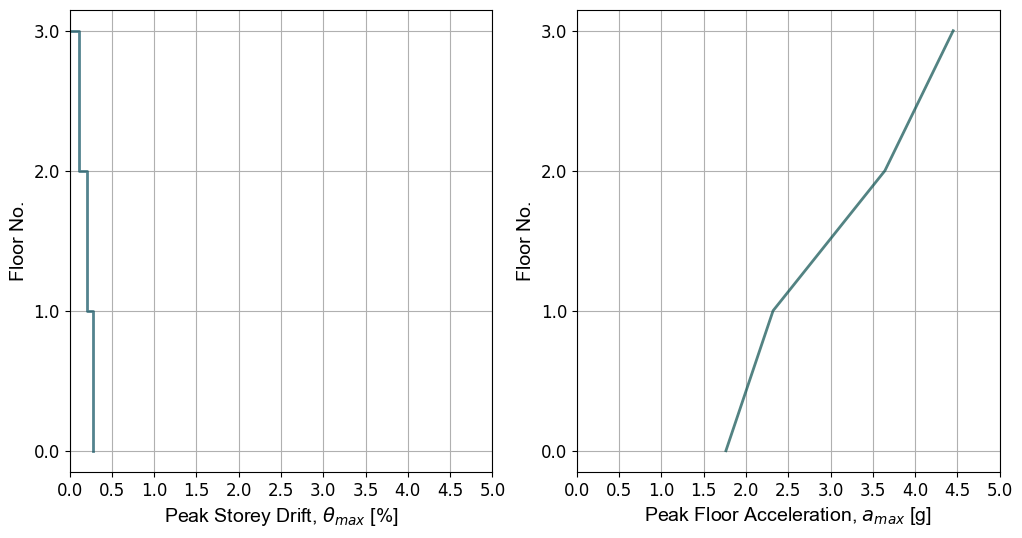

In [11]:
# Initialise the plotter class
pl = plotter()

## Visualise the seismic demands
pl.plot_demand_profiles(ansys_dict['peak_drift_list'], 
                        ansys_dict['peak_accel_list'], 
                        ansys_dict['control_nodes'], 
                        output_directory = None,
                        plot_label="seismic_demand_profiles") # The y-axis values of drift and acceleration are converted to % and g automatically by the plotter